In [1]:
library(tidyverse)
library(colorRamps)
library(qs2)
library(Seurat)
library(scupa)

Warning message:
“程序包‘purrr’是用R版本4.4.2 来建造的”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
qs2 0.1.4

载入需要的程序包：SeuratObject

载入需要的程序包：sp

Warning message:
“程序包‘sp’是用R版本4.4.2 来建造的”

载入程序包：‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
imm <- schard::h5ad2seurat('UCE/UCEimm_subset_uce_adata.h5ad')
imm[['uce']] <- CreateAssayObject(data=t(Embeddings(imm, 'Xuce_')))
DefaultAssay(imm) <- 'uce'
VariableFeatures(imm) <- rownames(imm)
imm

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


An object of class Seurat 
17651 features across 82888 samples within 2 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 1 other assay present: RNA
 1 dimensional reduction calculated: Xuce_

In [3]:
imm_anno = qs_read("seurat_objects/imm_anno.qs2")
imm_anno

imm_anno[['uce']] <- CreateAssayObject(data=t(Embeddings(imm, 'Xuce_')))
DefaultAssay(imm_anno) <- 'uce'
VariableFeatures(imm_anno) <- rownames(imm_anno)
imm_anno

An object of class Seurat 
51576 features across 82888 samples within 2 assays 
Active assay: SCT (25280 features, 3000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Layer counts isn't present in the assay object; returning NULL”


An object of class Seurat 
52856 features across 82888 samples within 3 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

# scupa

## B

An object of class Seurat 
52856 features across 3144 samples within 3 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
Loaded models and parameters for B

Measure polarization state: B-a

Measure polarization state: B-b

Measure polarization state: B-e

Measure polarization state: B-f

Warning message:
“No layers found matching search pattern provided”
Warning message:
“No layers found matching search pattern provided”
Warning message:
“The following requested variables were not found: B.c_score, B.d_score”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colou

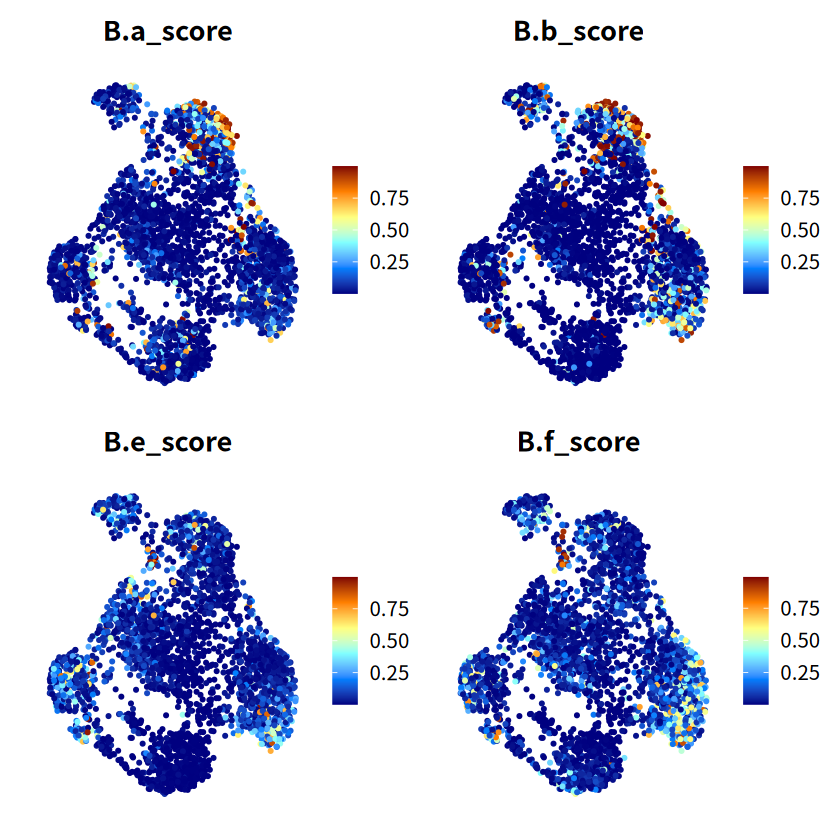

Saving 7 x 7 in image


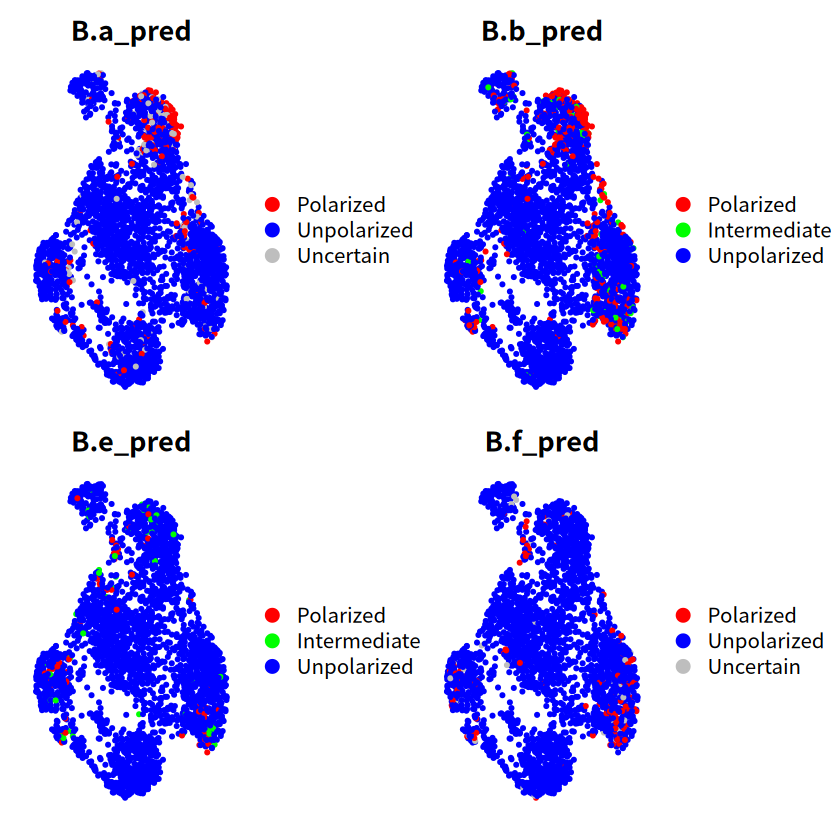

In [ ]:
B <- subset(imm_anno, cell_type_imm == 'B')

B <- B %>% 
    ScaleData() %>% 
    RunPCA(npcs = 50, verbose = FALSE) %>% 
    FindNeighbors(dims = 1:20, verbose=FALSE) %>% 
    FindClusters(resolution = 1, verbose=FALSE)%>% 
    RunUMAP(dims = 1:20, verbose=FALSE) 

B <- MeasurePolar(B, celltype='B')

FeaturePlot(B, c('B.a_score','B.b_score','B.c_score','B.d_score','B.e_score','B.f_score')) & 
    NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))

ggsave("scupa/B_FeaturePlot.png")

DimPlot(B, group.by=c('B.a_pred','B.b_pred','B.c_pred','B.d_score','B.e_pred','B.f_pred'), ncol=2) & 
    NoAxes() & scale_colour_manual(values = c('Polarized'='red','Intermediate'='green','Unpolarized'='blue','Uncertain'='gray'))
ggsave("scupa/B_DimPlot.png")

qs_save(B, "scupa/B.qs2")

# function

In [ ]:
process_cell_type <- function(cell_type, cell_data, resolution=1, npcs=50, dims=1:20) {

    # Perform data processing
    cell_data <- cell_data %>% 
        ScaleData() %>% 
        RunPCA(npcs = npcs, verbose = FALSE) %>% 
        FindNeighbors(dims = dims, verbose = FALSE) %>% 
        FindClusters(resolution = resolution, verbose = FALSE) %>% 
        RunUMAP(dims = dims, verbose = FALSE)
    
    # Measure polar scores
    cell_data <- MeasurePolar(cell_data, celltype=cell_type)

    if (cell_type == "CD8T") {
      cell_type = "T8"
      print(cell_type)
    }else if (cell_type == "CD4T"){
       cell_type = "T4"
       print(cell_type)
    }else {
        print(cell_type)
    }

    # Define score and prediction column names dynamically based on cell_type
    score_columns <- paste0(cell_type, c('.a_score', '.b_score', '.c_score', '.d_score', '.e_score', '.f_score'))
    pred_columns <- paste0(cell_type, c('.a_pred', '.b_pred', '.c_pred', '.d_pred', '.e_pred', '.f_pred'))
    
    # Plot FeaturePlot and save it
    feature_plot <- FeaturePlot(cell_data, score_columns) & 
        NoAxes() & scale_color_gradientn(colors=colorRamps::matlab.like(6))
    print(feature_plot)
    ggsave(paste0("scupa/", cell_type, "_FeaturePlot", ".png"), feature_plot)
    
    # Plot DimPlot and save it
    dim_plot <- DimPlot(cell_data, group.by=pred_columns, ncol=2) & 
        NoAxes() & scale_colour_manual(values = c('Polarized'='red', 'Intermediate'='green', 'Unpolarized'='blue', 'Uncertain'='gray'))
    print(dim_plot)
    ggsave(paste0("scupa/", cell_type, "_DimPlot",".png"), dim_plot)
    
    # Save the processed data
    qs_save(cell_data, paste0("scupa/", cell_type, ".qs2"))
    
    return(cell_data)
}


In [9]:
table(imm_anno@meta.data$cell_type_imm)


       Unknown Macs/Monos/DCs             NK              B       Alveolar 
         30314          30374          12216           3144           4381 
             T 
          2459 

An object of class Seurat 
52856 features across 2459 samples within 3 assays 
Active assay: uce (1280 features, 1280 variable features)
 1 layer present: data
 2 other assays present: RNA, SCT
 2 dimensional reductions calculated: pca, umap

Centering and scaling data matrix

Loaded models and parameters for CD4T

Measure polarization state: T4-a

Measure polarization state: T4-b

Measure polarization state: T4-c

Measure polarization state: T4-e

Measure polarization state: T4-f



[1] "T4"


Warning message:
“No layers found matching search pattern provided”
Warning message:
“The following requested variables were not found: T4.d_score”
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 7 x 7 in image
Warning message:
“The following requested variables were not found: T4.d_pred”


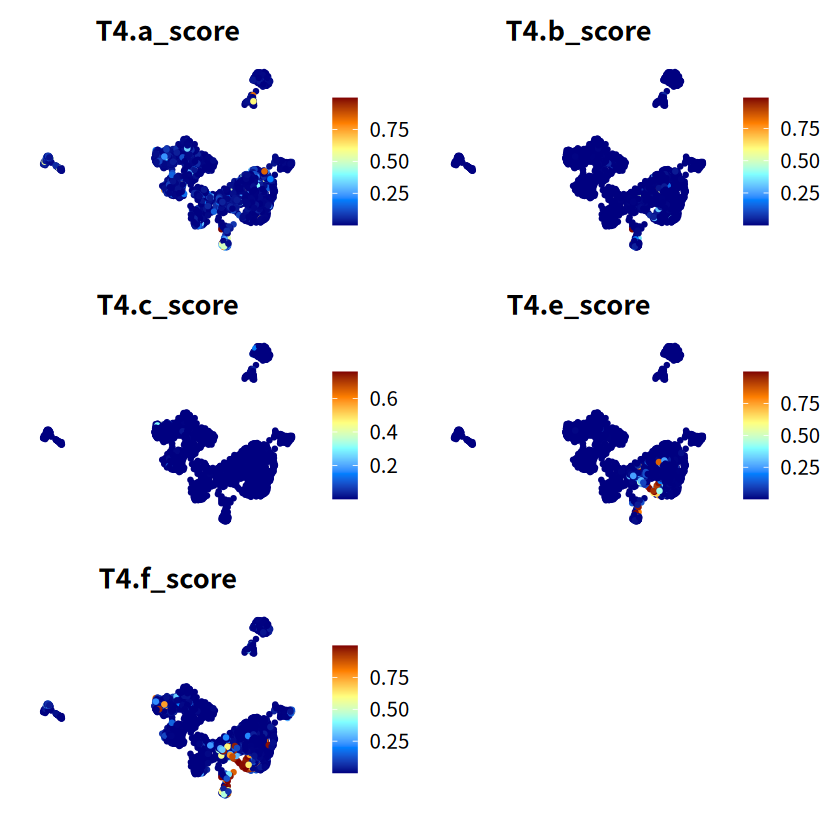

Saving 7 x 7 in image


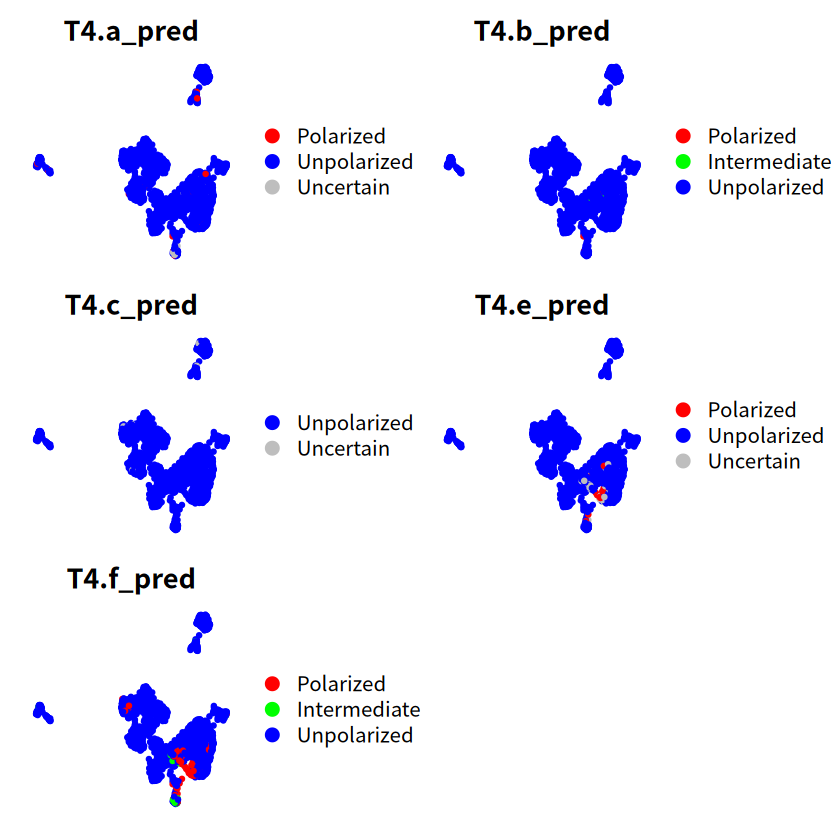

In [ ]:
# celltype: A string of cell type whose polarization will be measured.
#       Must be one of: B, NK, CD8T, CD4T, Treg, Tgd, pDC, cDC1,
#       cDC2, MigDC, LC, Macro, Mono, Neu.

T <- subset(imm_anno, cell_type_imm == 'T')
T
T_data <- process_cell_type('CD4T', T, resolution=1, npcs=50, dims=1:20)

In [24]:
rm(list=ls())
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,4152877,221.8,6853672,366.1,6853672,366.1
Vcells,45359002,346.1,2003736988,15287.4,2394967889,18272.2


# merge

In [27]:
B_data = qs_read('scupa/B.qs2')
NK_data = qs_read('scupa/NK.qs2')
T4_data = qs_read('scupa/T4.qs2')
# T8_data = qs_read('scupa/T8.qs2')
merge_data = merge(B_data, c(NK_data, T4_data))
qs_save(merge_data, "scupa/merge_data.qs2")